In [1]:
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from model.cnn_lstm import CNN_LSTM
from model.early_stopping import EarlyStopping
from dataset.preparetion import generate_data
from dataset.travel_time_dataset import TravelTimeDataset

In [2]:
cfg = {
    'data': {
        'path': 'E:/data/time_series_clean/start_stop/1.csv',
        'feature': 'delta_t',
        'window_size': 21,
        'train_split_size': 0.6,
        'val_split_size': 0.2
    },
    'plots': {
        'show_plots': True,
        'color_actual': '#001F3F',
        'color_train': '#3D9970',
        'color_val': '#0074D9',
        'color_test': '#FF4136',
        'color_pred_train': '#3D9970',
        'color_pred_val': '#0074D9',
        'color_pred_test': '#FF4136',
    },
    'model': {
        'lstm_hidden_size': 200,
        'lstm_num_layers': 1,
        'dropout': 0.7,
    },
    'optimizer': {
        'name': 'adam',
        'lr': 0.001,
        'beta': (0.9, 0.999),
        'eps': 1e-8,
        'momentum': 0.9,
        'weight_decay': 1e-6,
    },
    'scheduler': {
        'step_size': 10,
    },
    'train': {
        'device': 'cuda',
        'batch_size': 32,
        'num_epoch': 200,
        'checkpoint_path': 'E:/checkpoints/cnn_lstm',
    }
}

In [3]:
def download_data(cfg, plot):
    df = pd.read_csv(cfg['data']['path'], index_col=0, parse_dates=True)
    data_date = [date for date in df.index]
    data_date = np.array(data_date)
    data_date = data_date.reshape(-1, 1)
    
    data_travel_time = [float(df.loc[df.index == date][cfg['data']['feature']]) for date in df.index]
    data_travel_time = np.array(data_travel_time)
    data_travel_time = data_travel_time.reshape(-1, 1)

    num_data_points = len(data_date)
    print(f"Number data points: {num_data_points} from {data_date[0][0]} to {data_date[num_data_points - 1][0]}")
    
    if plot:
        road = (cfg['data']['path'].split('/')[-1]).split('.')[0]
        path = cfg['data']['path'].split('/')[-2]
        
        fig = plt.figure(figsize=(25, 5), dpi=80)
        fig.patch.set_facecolor((1.0, 1.0, 1.0))
        plt.plot(data_date, data_travel_time, color=cfg['plots']['color_actual']) 
        plt.title(f"Travel time of truck in road {road} and path {path}, from {data_date[0][0]} to {data_date[num_data_points - 1][0]}")
        plt.grid(b=None, which='major', axis='y', linestyle='--')
        plt.show()

    return data_date, data_travel_time, num_data_points

Number data points: 7413 from 2019-01-01 00:00:00 to 2019-12-31 20:00:00


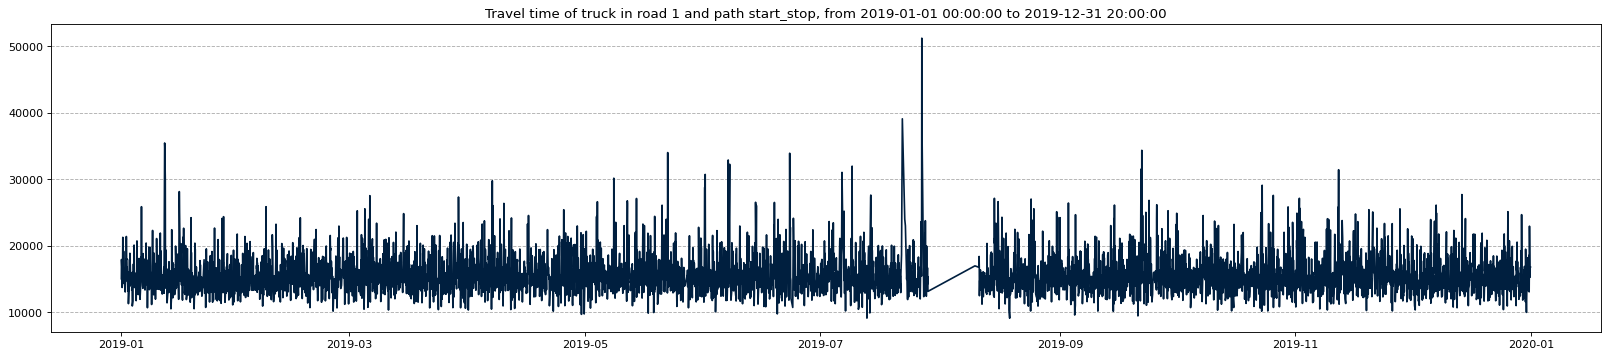

In [4]:
data_date, data_travel_time, num_data_points = download_data(cfg, cfg['plots']['show_plots'])

# Data preparation: normalize raw data

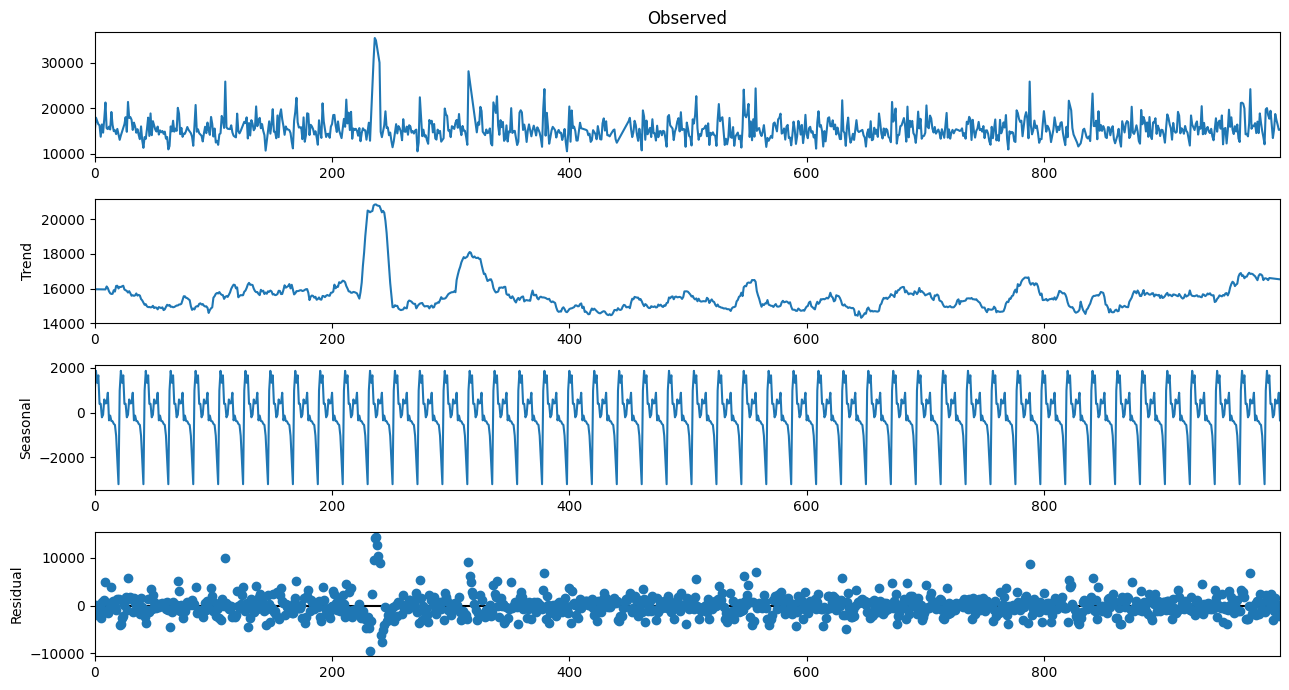

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(data_travel_time[:1000], model='additive', extrapolate_trend='freq', period=21)
plt.rcParams['figure.figsize'] = [13, 7]
fig = decomposition.plot()
plt.show()

In [6]:
scaler = StandardScaler()
normalize_data_travel_time = scaler.fit_transform(data_travel_time)

# Data preparation: generating training, test and validation data

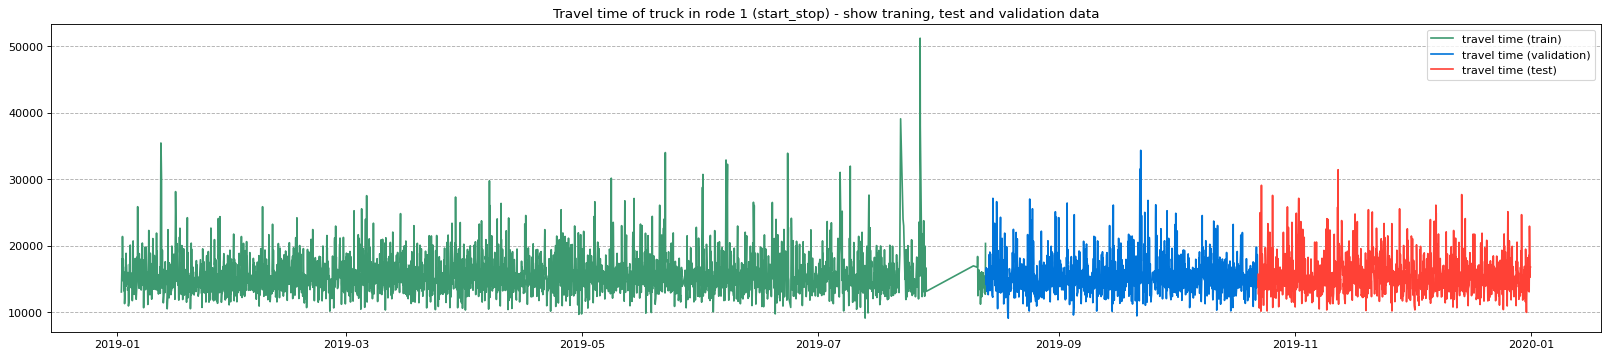

Train data shape: (4435, 21) (4435,)
Validation data shape: (1478, 21) (1478,)
Test data shape: (1479, 21) (1479,)


In [7]:
data_x_train, data_x_val, data_x_test, data_y_train, data_y_val, data_y_test, _, split_val_index = generate_data(normalize_data_travel_time, data_date, num_data_points, scaler, cfg, True)
print(f"Train data shape: {data_x_train.shape} {data_y_train.shape}")
print(f"Validation data shape: {data_x_val.shape} {data_y_val.shape}")
print(f"Test data shape: {data_x_test.shape} {data_y_test.shape}")

In [8]:
# create class dataset
dataset_train = TravelTimeDataset(data_x_train, data_y_train)
dataset_val = TravelTimeDataset(data_x_val, data_y_val)
dataset_test = TravelTimeDataset(data_x_test, data_y_test)

In [9]:
print(f"Train data for model shape: {dataset_train.x.shape} {dataset_train.y.shape}")
print(f"Validation data for model shape: {dataset_val.x.shape} {dataset_val.y.shape}")
print(f"Test data for model shape: {dataset_test.x.shape} {dataset_test.y.shape}")

Train data for model shape: (4435, 1, 21) (4435,)
Validation data for model shape: (1478, 1, 21) (1478,)
Test data for model shape: (1479, 1, 21) (1479,)


# Define CNN-LSTM Model

In [10]:
model = CNN_LSTM(lstm_hidde_size=cfg['model']['lstm_hidden_size'], lstm_num_layers=cfg['model']['lstm_num_layers'], dropout=cfg['model']['dropout'])
if torch.cuda.is_available():
    cfg['train']['device'] = 'cuda'
else:
    cfg['train']['device'] = 'cpu'
print(f"Training model use the {cfg['train']['device']}")
model = model.to(cfg['train']['device'])

Training model use the cpu


# Model Training

In [11]:
def train(dataset_train, dataset_val, model, cfg):
    # init tool for train model
    # craete dataloader
    train_dataloader = DataLoader(dataset_train, batch_size=cfg['train']['batch_size'], shuffle=True)
    val_dataloader = DataLoader(dataset_val, batch_size=cfg['train']['batch_size'], shuffle=False)

    # define optimizer, sheduler and loss function
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=cfg['optimizer']['lr'])
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=cfg['scheduler']['step_size'], gamma=0.5)
    early_stopping = EarlyStopping(patience=20, verbose=True, path=cfg['train']['checkpoint_path'])

    train_losses = []
    valid_losses = []
    avg_train_losses = []
    avg_valid_losses = []
    
    for epoch in range(cfg['train']['num_epoch']):
        print(f"Epoch: {epoch + 1}")

        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (x, y) in enumerate(train_dataloader):
            batch_size = x.shape[0]

            x = x.to(cfg['train']['device'])
            y = y.to(cfg['train']['device'])
            
            # prediction
            pred = model(x.float())
            loss = criterion(pred[:,0], y.float())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # add train loss
            train_losses.append(loss.item())

        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (x, y) in enumerate(val_dataloader):
            batch_size = x.shape[0]

            x = x.to(cfg['train']['device'])
            y = y.to(cfg['train']['device'])

            pred = model(x.float())
            loss = criterion(pred[:,0], y.float())

            # add valid loss
            valid_losses.append(loss.item())

        # update scheduler
        lr = scheduler.get_last_lr()[0]
        scheduler.step()

        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)

        print(f"[Epoch: {epoch + 1} / {cfg['train']['num_epoch']} || train_loss: {train_loss:.5f} || valid_loss: {valid_loss:.5f} || lr: {lr:.5f}]")

        train_losses = []
        valid_losses = []

        early_stopping(valid_loss, epoch, model, cfg)

        if early_stopping.early_stop:
            print('Early stopping')
            break

    return avg_train_losses, avg_valid_losses, early_stopping, model


In [12]:
train_losses, valid_losses, early_stopping, model = train(dataset_train, dataset_val, model, cfg)

Epoch: 1
[Epoch: 1 / 200 || train_loss: 1.01095 || valid_loss: 0.81188 || lr: 0.00100]
Validation loss decreased (inf --> 0.811885). Saving model ...
Epoch: 2
[Epoch: 2 / 200 || train_loss: 0.90034 || valid_loss: 0.81000 || lr: 0.00100]
Validation loss decreased (0.811885 --> 0.809996). Saving model ...
Epoch: 3
[Epoch: 3 / 200 || train_loss: 0.86445 || valid_loss: 0.80968 || lr: 0.00100]
Validation loss decreased (0.809996 --> 0.809682). Saving model ...
Epoch: 4
[Epoch: 4 / 200 || train_loss: 0.84808 || valid_loss: 0.83484 || lr: 0.00100]
EarlyStopping counter: 1 out of 20
Epoch: 5
[Epoch: 5 / 200 || train_loss: 0.82844 || valid_loss: 0.81633 || lr: 0.00100]
EarlyStopping counter: 2 out of 20
Epoch: 6
[Epoch: 6 / 200 || train_loss: 0.83892 || valid_loss: 0.80037 || lr: 0.00100]
Validation loss decreased (0.809682 --> 0.800366). Saving model ...
Epoch: 7
[Epoch: 7 / 200 || train_loss: 0.79246 || valid_loss: 0.85350 || lr: 0.00100]
EarlyStopping counter: 1 out of 20
Epoch: 8
[Epoch: 8 

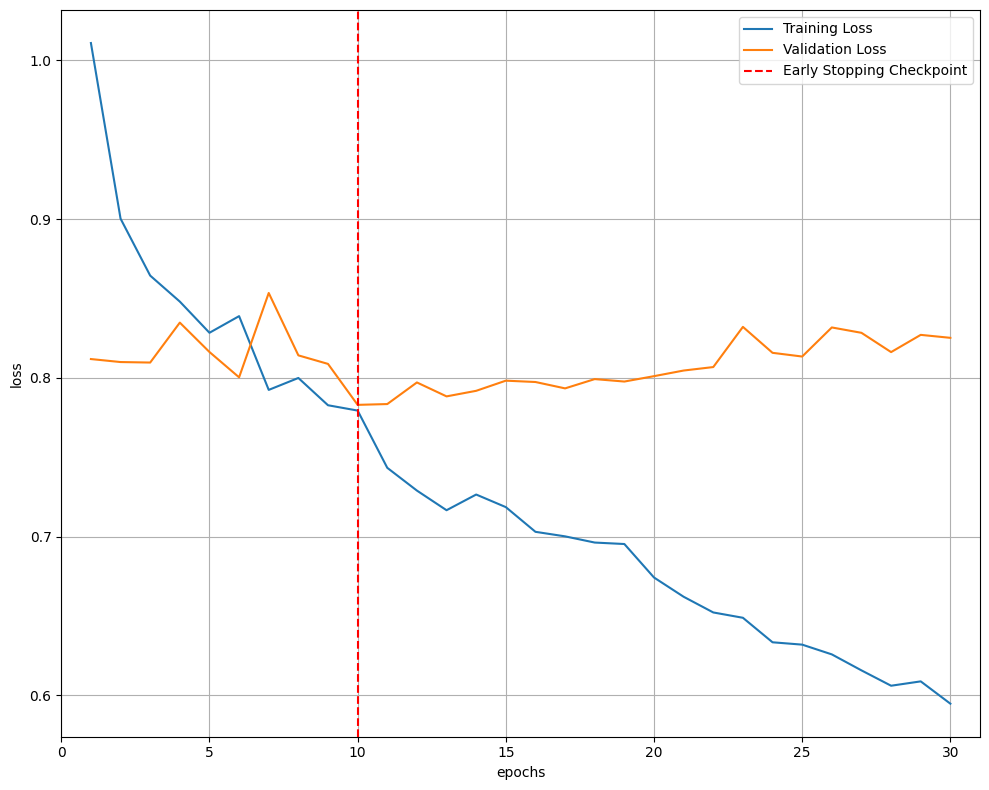

In [13]:
# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(valid_losses) + 1), valid_losses,label='Validation Loss')

# find position of lowest validation loss
minposs = np.where(valid_losses == early_stopping.val_loss_min)[0] + 1
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
# plt.ylim(0, 0.5) # consistent scale
plt.xlim(0, len(train_losses)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Model Evaluation

In [14]:
def eval(dataset_test, split_val_index, scaler, model, cfg, best_model_name, plot=False):
    # init tool for train model
    # craete dataloader
    test_dataloader = DataLoader(dataset_test, batch_size=cfg['train']['batch_size'], shuffle=False)

    checkpoint = torch.load(os.path.join(cfg['train']['checkpoint_path'], best_model_name + '.pth'))
    model.load_state_dict(checkpoint['net'])

    predicted_test = np.array([])

    model.eval()
    for batch_idx, (x, y) in enumerate(test_dataloader):
        x = x.to(cfg['train']['device'])
        pred = model(x.float())
        pred = pred.cpu().detach().numpy()
        predicted_test = np.concatenate((predicted_test, pred[:, 0]))

    mse = mean_squared_error(scaler.inverse_transform(dataset_test.y.reshape(1, -1)), scaler.inverse_transform(predicted_test.reshape(1, -1)))
    rmse = math.sqrt(mean_squared_error(scaler.inverse_transform(dataset_test.y.reshape(1, -1)), scaler.inverse_transform(predicted_test.reshape(1, -1))))
    mae = mean_absolute_error(scaler.inverse_transform(dataset_test.y.reshape(1, -1)), scaler.inverse_transform(predicted_test.reshape(1, -1)))

    print(f"MSE : {mse}")
    print(f"RMSE : {rmse}")
    print(f"MAE : {mae}")

    if plot:
        road = (cfg['data']['path'].split('/')[-1]).split('.')[0]
        path = cfg['data']['path'].split('/')[-2]

        to_plot_data_y_test_subset = scaler.inverse_transform(dataset_test.y.reshape(-1, 1))
        to_plot_predicted_test = scaler.inverse_transform(predicted_test.reshape(-1, 1))
        to_plot_data_date = data_date[split_val_index + cfg['data']['window_size']:]

        #plot
        fig = plt.figure(figsize=(25, 5), dpi=80)
        fig.patch.set_facecolor((1.0, 1.0, 1.0))
        plt.plot(to_plot_data_date, to_plot_data_y_test_subset, label='Actual travel time', color=cfg['plots']['color_actual'])
        plt.plot(to_plot_data_date, to_plot_predicted_test, label='Predicted travel time (test)', color=cfg['plots']['color_pred_test'])
        plt.title(f"Examine predicted travel time on test data portion of road {road} ({path}) [MSE: {mse:.3f} | RMSE: {rmse:.3f} | MAE: {mae:.3f}]")
        plt.grid(b=None, which='major', axis='y', linestyle='--')
        plt.legend()
        plt.show()

In [ ]:
eval(dataset_test, split_val_index, scaler, model, cfg, 'lstm_6_0.785', True)